## 1. **Business Understanding**

### Overview

SentimentFlow aims to address a real-world problem related to understanding public sentiment towards Apple and Google products on Twitter. The stakeholders include companies, marketing teams, and decision-makers who want to gauge public opinion and make informed strategic decisions based on social media sentiment.

### Problem Statement

The problem is to accurately classify the sentiment of tweets related to Apple and Google products. We want to determine whether a tweet expresses a positive, negative, or neutral sentiment. This classification can help companies understand customer satisfaction, identify potential issues, and tailor their responses accordingly.

### Objectives

Main Objective

> To develop a NLP (Natural Language Processing) multiclass classification model for sentiment analysis, aim to achieve a recall score of 80% and an accuracy of 80%. The model should categorize sentiments into three classes: Positive, Negative, and Neutral.

Specific Objectives

* To idenitfy the most common words used in the dataset using Word cloud.

* To confirm the most common words that are positively and negatively tagged.

* To recognize the products that have been opined by the users.

* To spot the distribution of the sentiments.

## 2. **Data Understanding**

### Data Sources
The dataset originates from CrowdFlower via data.world. Contributors evaluated tweets related to various brands and products. Specifically:
- Each tweet was labeled as expressing positive, negative, or no emotion toward a brand or product.
- If emotion was expressed, contributors specified which brand or product was the target.

### Suitability of Data
Here's why this dataset is suitable for our project:
1. **Relevance:** The data directly aligns with our business problem of understanding Twitter sentiment for Apple and Google products.
2. **Real-World Context:** The tweets represent actual user opinions, making the problem relevant in practice.
3. **Multiclass Labels:** We can build both binary (positive/negative) and multiclass (positive/negative/neutral) classifiers using this data.

### Dataset Size
The dataset contains over 9,000 labeled tweets. We'll explore its features to gain insights.

### Descriptive Statistics
- **tweet_text:** The content of each tweet.
- **is_there_an_emotion_directed_at_a_brand_or_product:** No emotion toward brand or product, Positive emotion, Negative emotion, I can't tell
- **emotion_in_tweet_is_directed_at:** The brand or product mentioned in the tweet.

### Feature Inclusion
Tweet text is the primary feature. The emotion label and target brand/product are essential for classification.

### Limitations
- **Label Noise:** Human raters' subjectivity may introduce noise.
- **Imbalanced Classes:** We'll address class imbalance during modeling.
- **Contextual Challenges:** Tweets are often short and context-dependent.
- **Incomplete & Missing Data:** Could affect the overall performance of the models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


Load and Inspect data

In [ ]:
# from typing_extensions import dataclass_transform
class DataUnderstanding:
  """Class for understanding the characteristics of the dataset"""
  def __init__(self, data= None):
    """Initialize the class with a DataFrame"""
    self.df= data

  def load_data(self, path):
    """Load data from a CSV file"""
    if self.df is None:
      self.df = pd.read_csv(path, encoding= 'latin-1')
    return self.df

  def preview_df(self):
    """Preview the DataFrame"""
    print("\n\nHEAD")
    print("-"*22)
    print(self.df.head())

  def display_info(self):
    """Display information about the DataFrame"""
    print("\n\nINFO")
    print("-"*22)
    print(self.df.info())

  def display_shape(self):
    """Display the shape of the DataFrame"""
    print("\n\nSHAPE")
    print("-"*22)
    print(f"Records: {self.df.shape[0]}, Features: {self.df.shape[1]}")

  def display_columns(self):
    """Display the columns in the dataset."""
    print("\nCOLUMNS")
    print("-" *22)
    for col in self.df.columns:
      print(f"- {col}")


  def display_missing_values(self):
    """Display missing values in each column"""
    print("\n\nMISSING VALUES")
    print("-"*22)
    for col in self.df.columns:
      print(f"{col}: {self.df[col].isnull().sum()}")

  def display_duplicates(self):
    """Display duplicate records in the DataFrame"""
    print("\n\nDUPLICATES")
    print("-"*22)
    print(f"Duplicate records: {self.df.duplicated().sum()}")

  def understand_data(self):
    """Display dataset overview"""
    self.preview_df()
    self.display_info()
    self.display_shape()
    self.display_columns()
    self.display_missing_values()
    self.display_duplicates()




In [ ]:
# Load Data
data_und = DataUnderstanding()

df = data_und.load_data('/content/drive/MyDrive/phase_4_project/sentiment-analysis/judge-1377884607_tweet_product_company.csv')

data_und.understand_data()



HEAD
----------------------
                                          tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  


INFO
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

In essence, the dataset is designed to analyze sentiment, whether positive or negative, from tweets involving different products or brands.

The majority of these tweets - 5802 - don't specify any product or brand for which some decisions may be required in pre-processing.

The dataset is fairly clean; there are a few missing values in the 'tweet_text' and 'emotion_in_tweet_is_directed_at' columns and few duplicates.

Data Cleaning

In [ ]:
#renaming columns for easier reference
df.rename (columns= {
    'tweet_text': 'tweets',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
}, inplace=True)

Handling duplicates

In [ ]:
df.drop_duplicates(subset= 'tweets', inplace= True)

Handling missing values

In [ ]:
# Drop the 1 in tweets column
df = df.dropna(subset=['tweets'])

In [ ]:
# imputing missing values in product column with data from tweets

product_list = df['product'].unique()
product_list = [product for product in product_list if str(product) != 'nan']

def extract_product(tweet):
    for product in product_list:
        if product.lower() in tweet.lower():
            return product
    return None

df.loc[:, 'product']  = df.apply(lambda x: extract_product(x['tweets']) if pd.isna(x['product']) else x['product'], axis=1,)

df.head(5)

,tweets,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [ ]:
df['product'].isnull().sum()

759

In [ ]:
# drop the remaining
df = df.dropna(subset=['product'])

In [ ]:
#check distribution of emotions
df['emotion'].value_counts()

,count
emotion,
No emotion toward brand or product,4633
Positive emotion,2955
Negative emotion,568
I can't tell,150


In [ ]:
#drop records where emotion is i can't tell
df = df.drop(df[df['emotion'] == "I can't tell"].index)

In [ ]:
# label emotion as 'positive', 'negative' and 'neutral'
df.loc[:, 'sentiment'] = df['emotion'].apply(lambda x: 'positive' if x == 'Positive emotion' else ('negative' if x == 'Negative emotion' else 'neutral'))
df.head()

,tweets,product,emotion,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,positive


In [ ]:
#Ensure cleaning process worked effectively
data_und = DataUnderstanding(df)

data_und.understand_data()



HEAD
----------------------
                                              tweets             product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

            emotion sentiment  
0  Negative emotion  negative  
1  Positive emotion  positive  
2  Positive emotion  positive  
3  Negative emotion  negative  
4  Positive emotion  positive  


INFO
----------------------
<class 'pandas.core.frame.DataFrame'>
Index: 8156 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     8156 non-null   object
 1   product    8156 non-null   object
 2   emotion    8156 non-null   ob

**Exploratory Data Analysis**

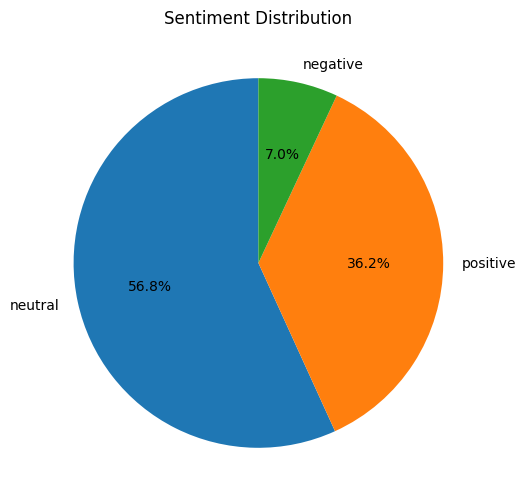

In [ ]:
#sentiment distribution
sentiment_counts = df['sentiment'].value_counts()

# piechart
plt.figure(figsize=(8, 6))
labels= sentiment_counts.index
plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()


Class Imbalance is evident, seeing as more than 50% of the tweets convey neutral emotion and approximately 7% convey negative emotion.

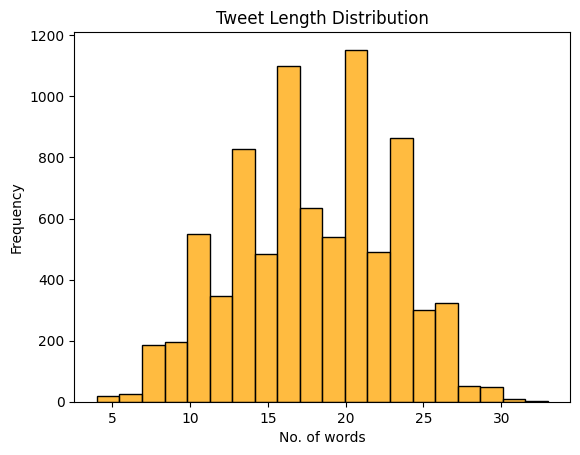

In [ ]:
# tweet length distribution
df['tweet_length'] = df['tweets'].apply(lambda x: len(x.split()))

sns.histplot(df['tweet_length'], bins=20, color= 'orange')
plt.title('Tweet Length Distribution')
plt.xlabel('No. of words')
plt.ylabel('Frequency')
plt.show()


The tweets range between 4 and 33 words

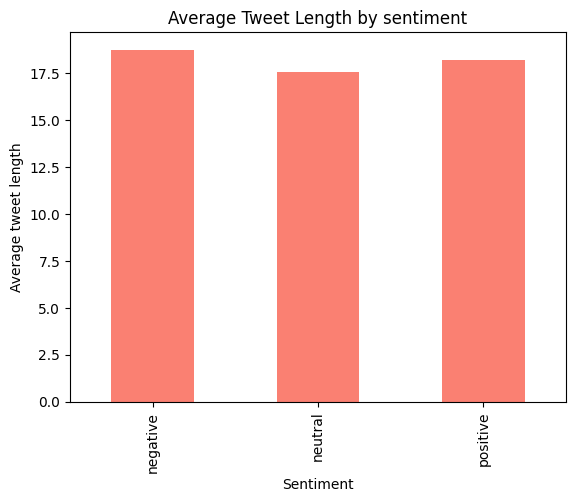

In [ ]:
#Class Distribution by tweet length
df.groupby('sentiment')['tweet_length'].mean().plot(kind='bar', color= 'salmon')
plt.title('Average Tweet Length by sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average tweet length')
plt.show()


The bar chart indicates that the average tweet length for all three sentiment categories (positive, negative, and neutral) is almost equal, ranging between 17 to 18 words, suggesting that tweet length is consistent across different sentiments.

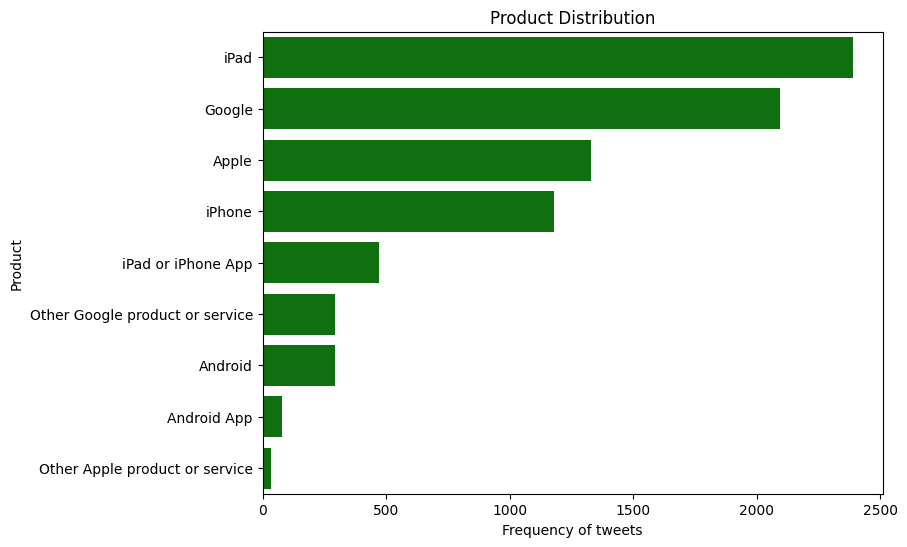

,count
product,
iPad,2390
Google,2093
Apple,1328
iPhone,1178
iPad or iPhone App,469
Other Google product or service,292
Android,291
Android App,80
Other Apple product or service,35


In [ ]:
#Distribution of products
product_counts= df['product'].value_counts()

plt.figure(figsize= (8, 6))
labels= product_counts.index
sns.barplot(x= product_counts, y= labels, color= 'green')
plt.title('Product Distribution')
plt.xlabel('Frequency of tweets')
plt.ylabel('Product')
plt.show()

product_counts

The distribution plot of product distribution shows that iPad is the most mentioned product among the tweets, followed by Google and Apple, which proves these brands are on the hotlist and much discussed, whereas the rest of the products like Android and Apple services have been talked about far less.

<Figure size 800x600 with 0 Axes>

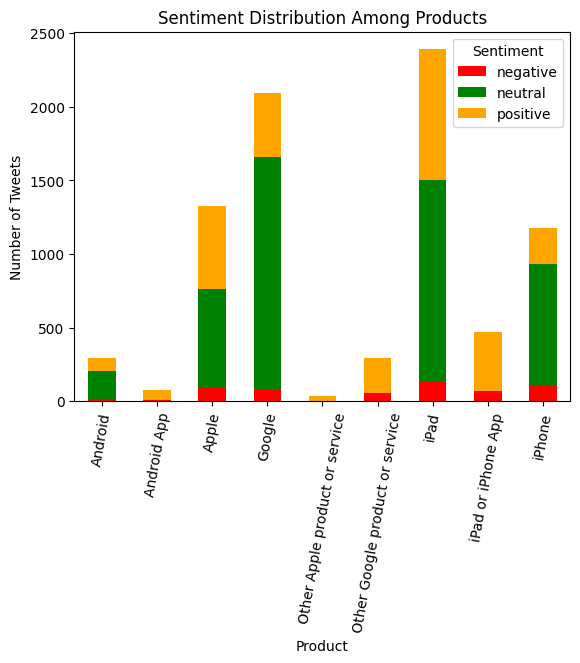

In [ ]:
#Sentiment distribution for each product
product_sentiment_counts = df.groupby('product')['sentiment'].value_counts().unstack().fillna(0)

#plot
plt.figure(figsize=(8, 6))

# Plot the sentiment distribution for each product
product_sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'green', 'orange'])

plt.title('Sentiment Distribution Among Products')
plt.xlabel('Product')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=80)
plt.legend(title='Sentiment', labels=product_sentiment_counts.columns)

plt.show()


**Data Preprocessing**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# text preprocessing

class TextCleaner(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_text(text):
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
            text = re.sub(r'@\w+', '', text)  # Remove mentions
            text = re.sub(r'#\w+', '', text)  # Remove hashtags
            text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
            text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
            return text
        return [clean_text(text) for text in X]

class LowerCaseConverter(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [text.lower() for text in X]

class StopwordRemover(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stop_words = set(stopwords.words('english'))
        return [' '.join([word for word in text.split() if word not in stop_words]) for text in X]

class Tokenizer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [word_tokenize(text) for text in X]

class Lemmatizer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmatizer = WordNetLemmatizer()
        # Process each token list and lemmatize tokens
        return [[lemmatizer.lemmatize(word) for word in tokens] for tokens in X]



In [ ]:
# Pipeline for text preprocessing
text_preprocessing_pipeline = Pipeline([
    ('cleaner', TextCleaner()),
    ('lower_case_converter', LowerCaseConverter()),
    ('stopwords_remover', StopwordRemover()),
    ('tokenizer', Tokenizer()),
    ('lemmatizer', Lemmatizer())
])

df['processed_tweets'] = text_preprocessing_pipeline.fit_transform(df['tweets'])

df['cleaned_tweets'] = df['processed_tweets'].apply(lambda tokens: ' '.join(tokens))

df[['tweets', 'cleaned_tweets']].head(5)


,tweets,cleaned_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,g iphone hr tweeting dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim oreil...


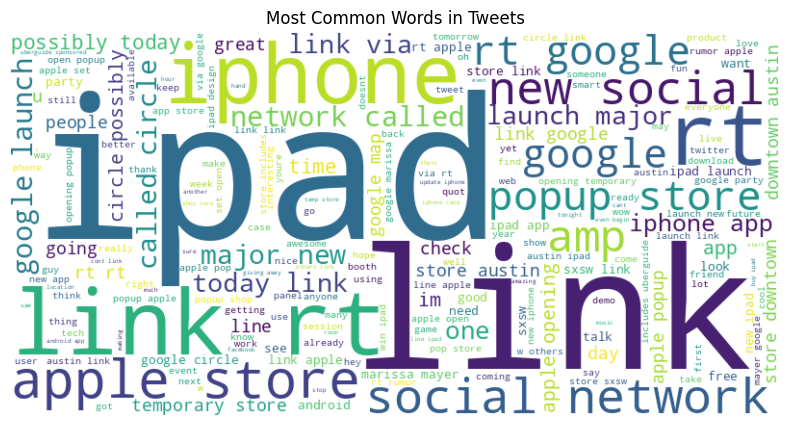

In [ ]:
from wordcloud import WordCloud

# Combine all tweets into a single string for word cloud
all_words = ' '.join(df['cleaned_tweets'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Tweets')
plt.show()


**Feature Extraction**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Encode the target variable
label_encoder = LabelEncoder()
df['sentiment_enc'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
#Define vectorizers and SMOTE pipeline
cv = CountVectorizer()
tfidf = TfidfVectorizer()
smote = SMOTE(random_state=42)


In [ ]:
#Pipeline for vectorizers and SMOTE
def vectorizer_pipeline(model, vectorizer):
    return ImbPipeline([
        ('vectorizer', vectorizer),
        ('smote', smote),
        ('model', model)
    ])


Data Preparation

In [ ]:
#Filter the dataset to only include positive and negative sentiments
binary_df = df[df['sentiment_enc'].isin([0, 1])].reset_index(drop=True)

# Define features and target for binary classification
X_binary = binary_df['cleaned_tweets']
y_binary = binary_df['sentiment_enc']

# Split the data into training and testing sets
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

*Define models and results dataframe*

In [ ]:
# Define the models for binary classification
binary_models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Dataframe to store results for untuned models
binary_results = pd.DataFrame(columns=[
    'Model',
    'Vectorizer',
    'Accuracy',
    'Precision (Class 0)',
    'Recall (Class 0)',
    'F1-Score (Class 0)',
    'Precision (Class 1)',
    'Recall (Class 1)',
    'F1-Score (Class 1)',
    'Confusion Matrix'
])

# Dataframe to store results for tuned models
tuned_results = pd.DataFrame(columns=[
    'Model',
    'Vectorizer',
    'Best Parameters',
    'Accuracy',
    'Precision (Class 0)',
    'Recall (Class 0)',
    'F1-Score (Class 0)',
    'Precision (Class 1)',
    'Recall (Class 1)',
    'F1-Score (Class 1)',
    'Confusion Matrix'
])


Define Pipeline Creation

In [ ]:
# Function to create the pipeline
def create_pipeline(model, vectorizer_name):
    if vectorizer_name == 'CountVectorizer':
        return Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ])
    else:
        return Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', model)
        ])


Define Evaluation Function

In [ ]:
# Function to fit and evaluate binary models
def evaluate_binary_models(models, X_train, y_train, X_test, y_test, vectorizer_name, tuned=False):
    for name, model in models.items():
        pipeline = create_pipeline(model, vectorizer_name)
        if tuned:
            # Define the parameter grid
            param_grid = {}
            if name == 'Logistic Regression':
                param_grid['classifier__C'] = [0.1, 1, 10]
            elif name == 'Random Forest':
                param_grid['classifier__n_estimators'] = [50, 100]
            elif name == 'SVM':
                param_grid['classifier__kernel'] = ['linear', 'rbf']

            # Setup the grid search
            grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
            grid_search.fit(X_train, y_train)

            # Get the best model
            best_model = grid_search.best_estimator_

            # Predict on the test set
            y_pred = best_model.predict(X_test)

            # Calculate evaluation metrics
            report = classification_report(y_test, y_pred, output_dict=True)
            accuracy = report['accuracy']

            # Create a confusion matrix
            cm = confusion_matrix(y_test, y_pred)

            # Extract key metrics
            key_metrics = {
                'Model': name,
                'Vectorizer': vectorizer_name,
                'Best Parameters': grid_search.best_params_,
                'Accuracy': accuracy,
                'Precision (Class 0)': report['0']['precision'],
                'Recall (Class 0)': report['0']['recall'],
                'F1-Score (Class 0)': report['0']['f1-score'],
                'Precision (Class 1)': report['1']['precision'],
                'Recall (Class 1)': report['1']['recall'],
                'F1-Score (Class 1)': report['1']['f1-score'],
                'Confusion Matrix': cm.tolist()
            }

            # Store the key metrics in the tuned results DataFrame
            tuned_results.loc[len(tuned_results)] = key_metrics

        else:
            # Fit the untuned model
            pipeline.fit(X_train, y_train)

            # Predict on the test set
            y_pred = pipeline.predict(X_test)

            # Calculate evaluation metrics
            report = classification_report(y_test, y_pred, output_dict=True)
            accuracy = report['accuracy']

            # Create a confusion matrix
            cm = confusion_matrix(y_test, y_pred)

            # Extract key metrics
            key_metrics = {
                'Model': name,
                'Vectorizer': vectorizer_name,
                'Accuracy': accuracy,
                'Precision (Class 0)': report['0']['precision'],
                'Recall (Class 0)': report['0']['recall'],
                'F1-Score (Class 0)': report['0']['f1-score'],
                'Precision (Class 1)': report['1']['precision'],
                'Recall (Class 1)': report['1']['recall'],
                'F1-Score (Class 1)': report['1']['f1-score'],
                'Confusion Matrix': cm.tolist()
            }

            # Store the key metrics in the results DataFrame
            binary_results.loc[len(binary_results)] = key_metrics


Evaluate Models

In [ ]:
# Evaluate binary classifiers with both vectorizers for untuned models
for vectorizer in ['CountVectorizer', 'TfidfVectorizer']:
    evaluate_binary_models(binary_models, X_train_bin, y_train_bin, X_test_bin, y_test_bin, vectorizer, tuned=False)

# Evaluate binary classifiers with both vectorizers for tuned models
for vectorizer in ['CountVectorizer', 'TfidfVectorizer']:
    evaluate_binary_models(binary_models, X_train_bin, y_train_bin, X_test_bin, y_test_bin, vectorizer, tuned=True)


Untuned Binary Classification Results:

Tuned Binary Classification Results:


In [ ]:
def display_results(binary_results, tuned_results):
    print("### Untuned Binary Classification Results\n")
    print(binary_results.to_markdown(index=False))

    print("\n### Tuned Binary Classification Results\n")
    print(tuned_results.to_markdown(index=False))

# Example usage
display_results(binary_results, tuned_results)

### Untuned Binary Classification Results

| Model               | Vectorizer      |   Accuracy |   Precision (Class 0) |   Recall (Class 0) |   F1-Score (Class 0) |   Precision (Class 1) |   Recall (Class 1) |   F1-Score (Class 1) | Confusion Matrix      |
|:--------------------|:----------------|-----------:|----------------------:|-------------------:|---------------------:|----------------------:|-------------------:|---------------------:|:----------------------|
| Logistic Regression | CountVectorizer |   0.908742 |              0.627907 |          0.254717  |            0.362416  |              0.920842 |           0.982888 |             0.950854 | [[27, 79], [16, 919]] |
| Random Forest       | CountVectorizer |   0.915466 |              0.764706 |          0.245283  |            0.371429  |              0.920556 |           0.991444 |             0.954686 | [[26, 80], [8, 927]]  |
| SVM                 | CountVectorizer |   0.907781 |              0.857143 |          0.113208 

Multiclass Classification

Data Preparation

In [ ]:
# Step 1: Filter the original dataset to include all sentiment classes (negative, positive, neutral)
multi_df = df.copy()
multi_df = multi_df[multi_df['sentiment_enc'].isin([0, 1, 2])].reset_index(drop=True)

print(f"Total tweets for multiclass classification: {multi_df.shape[0]}")
print("Sentiment distribution:\n", multi_df['sentiment_enc'].value_counts())

# Splitting the dataset into features and target variable
X_multi = multi_df['cleaned_tweets']
y_multi = multi_df['sentiment_enc']

# Split the dataset into training and testing sets
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi)

Total tweets for multiclass classification: 8156
Sentiment distribution:
 sentiment_enc
1    4633
2    2955
0     568
Name: count, dtype: int64


Define Models and Results DaataFrame

In [ ]:
# Define the models for multiclass classification
multi_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Multinomial Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss')
}

# Dataframe to store results for untuned models
multi_results = pd.DataFrame(columns=[
    'Model',
    'Vectorizer',
    'Accuracy',
    'Precision (Class 0)',
    'Recall (Class 0)',
    'F1-Score (Class 0)',
    'Precision (Class 1)',
    'Recall (Class 1)',
    'F1-Score (Class 1)',
    'Precision (Class 2)',
    'Recall (Class 2)',
    'F1-Score (Class 2)',
    'Confusion Matrix'
])

# Dataframe to store results for tuned models
tuned_multi_results = pd.DataFrame(columns=[
    'Model',
    'Vectorizer',
    'Best Parameters',
    'Accuracy',
    'Precision (Class 0)',
    'Recall (Class 0)',
    'F1-Score (Class 0)',
    'Precision (Class 1)',
    'Recall (Class 1)',
    'F1-Score (Class 1)',
    'Precision (Class 2)',
    'Recall (Class 2)',
    'F1-Score (Class 2)',
    'Confusion Matrix'
])


Pipeline Creation

In [ ]:
# Function to create the pipeline
def create_pipeline(model, vectorizer_name):
    if vectorizer_name == 'CountVectorizer':
        return Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ])
    else:
        return Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', model)
        ])


Evaluation Function

In [ ]:
# Function to fit and evaluate multiclass models
def evaluate_multiclass_models(models, X_train, y_train, X_test, y_test, vectorizer_name, tuned=False):
    for name, model in models.items():
        pipeline = create_pipeline(model, vectorizer_name)

        if tuned:
            # Define the parameter grid
            param_grid = {}
            if name == 'Logistic Regression':
                 param_grid['classifier__C'] = [0.1, 1, 10]
            elif name == 'Random Forest':
                param_grid['classifier__n_estimators'] = [50, 100]
            elif name == 'Multinomial Naive Bayes':
                param_grid['classifier__alpha'] = [0.1, 1, 10]
            elif name == 'XGBoost':
                param_grid['classifier__max_depth'] = [3, 5, 7]


            if param_grid:
                grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
                grid_search.fit(X_train, y_train)

                # Get the best model
                best_model = grid_search.best_estimator_

                # Predict on the test set
                y_pred = best_model.predict(X_test)

                # Calculate evaluation metrics
                report = classification_report(y_test, y_pred, output_dict=True)
                accuracy = report['accuracy']

                # Create a confusion matrix
                cm = confusion_matrix(y_test, y_pred)

                # Extract key metrics
                key_metrics = {
                    'Model': name,
                    'Vectorizer': vectorizer_name,
                    'Best Parameters': grid_search.best_params_,
                    'Accuracy': accuracy,
                    'Precision (Class 0)': report['0']['precision'],
                    'Recall (Class 0)': report['0']['recall'],
                    'F1-Score (Class 0)': report['0']['f1-score'],
                    'Precision (Class 1)': report['1']['precision'],
                    'Recall (Class 1)': report['1']['recall'],
                    'F1-Score (Class 1)': report['1']['f1-score'],
                    'Precision (Class 2)': report['2']['precision'],
                    'Recall (Class 2)': report['2']['recall'],
                    'F1-Score (Class 2)': report['2']['f1-score'],
                    'Confusion Matrix': cm.tolist()
                }

                # Store the key metrics in the tuned results DataFrame
                tuned_multi_results.loc[len(tuned_multi_results)] = key_metrics

        else:
            # Fit the untuned model
            pipeline.fit(X_train, y_train)

            # Predict on the test set
            y_pred = pipeline.predict(X_test)

            # Calculate evaluation metrics
            report = classification_report(y_test, y_pred, output_dict=True)
            accuracy = report['accuracy']

            # Create a confusion matrix
            cm = confusion_matrix(y_test, y_pred)

            # Extract key metrics
            key_metrics = {
                'Model': name,
                'Vectorizer': vectorizer_name,
                'Accuracy': accuracy,
                'Precision (Class 0)': report['0']['precision'],
                'Recall (Class 0)': report['0']['recall'],
                'F1-Score (Class 0)': report['0']['f1-score'],
                'Precision (Class 1)': report['1']['precision'],
                'Recall (Class 1)': report['1']['recall'],
                'F1-Score (Class 1)': report['1']['f1-score'],
                'Precision (Class 2)': report['2']['precision'],
                'Recall (Class 2)': report['2']['recall'],
                'F1-Score (Class 2)': report['2']['f1-score'],
                'Confusion Matrix': cm.tolist()
            }

            # Store the key metrics in the results DataFrame
            multi_results.loc[len(multi_results)] = key_metrics



Evaluate models

In [ ]:
# Evaluate multiclass classifiers with both vectorizers for untuned models
for vectorizer in ['CountVectorizer', 'TfidfVectorizer']:
    evaluate_multiclass_models(multi_models, X_train_multi, y_train_multi, X_test_multi, y_test_multi, vectorizer, tuned=False)

# Evaluate multiclass classifiers with both vectorizers for tuned models
for vectorizer in ['CountVectorizer', 'TfidfVectorizer']:
    evaluate_multiclass_models(multi_models, X_train_multi, y_train_multi, X_test_multi, y_test_multi, vectorizer, tuned=True)


In [ ]:
def display_results(multi_results, tuned_multi_results):
    print("### Untuned MUlticlass Classification Results\n")
    print(multi_results.to_markdown(index=False))

    print("\n### Tuned Multiclass Classification Results\n")
    print(tuned_multi_results.to_markdown(index=False))

# Example usage
display_results(multi_results, tuned_multi_results)

### Untuned MUlticlass Classification Results

| Model                   | Vectorizer      |   Accuracy |   Precision (Class 0) |   Recall (Class 0) |   F1-Score (Class 0) |   Precision (Class 1) |   Recall (Class 1) |   F1-Score (Class 1) |   Precision (Class 2) |   Recall (Class 2) |   F1-Score (Class 2) | Confusion Matrix                              |
|:------------------------|:----------------|-----------:|----------------------:|-------------------:|---------------------:|----------------------:|-------------------:|---------------------:|----------------------:|-------------------:|---------------------:|:----------------------------------------------|
| Logistic Regression     | CountVectorizer |   0.674632 |              0.574074 |         0.27193    |            0.369048  |              0.696097 |           0.807983 |             0.747878 |              0.639442 |           0.543147 |             0.587374 | [[31, 61, 22], [19, 749, 159], [4, 266, 321]] |
| Random Forest     